# YOLO DS-II method analysis and final errors for DS-II
- Notebook of predictions, labelling and training is performed in the other one

In [ ]:
NOTEBOOK_CONFIG = {
    "label_mode": True,
    "train_mode": True,
    "IMG_LENGTH": 180,
    "IMG_WIDTH": 72,
    "IMG_XDIM": 72,
    "IMG_YDIM": 180,
    "image_ranges": [(0, 72), (0, 180)],
    "image_size": [72, 180],
    "labels_type": "Labelsv0_T80kenji_detect",
    "task": "detect",
    "model_name": "YOLOv0_T80kenji_detect",
}

In [2]:
# Folders
# Location of images
images_folder = f"../docs/Data/Images_T80kenji/"
# Locations of yolo's datasets
yolo_folder = f"../docs/Models/{NOTEBOOK_CONFIG['yolo_type']}/datasets/"
# Location of labels
labels_folder = f"../docs/Data/{NOTEBOOK_CONFIG['labels_type']}/"
# Location of trained models
model_folder = f"../docs/Models/{NOTEBOOK_CONFIG['yolo_type']}/"

In [3]:
# Path for sample image
n_image = 313
image_path = f"../docs/Data/Images_T80kenji/gaussian_{n_image}.png"
label_path = f"../docs/Data/{NOTEBOOK_CONFIG['labels_type']}/gaussian_{n_image}.txt"

In [4]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
import h5py
import os
import pandas as pd
import numpy as np

from datetime import datetime
import scipy.io

from matplotlib import pyplot as plt
from adjustText import adjust_text

In [ ]:
from ultralytics import YOLO
import cv2
from PIL import Image

# Load modules

In [15]:
# Training runs (best)
bst_run = {
    "YOLOv0_detect": "2023-07-26_18-50-24",
    "YOLOv0_E2_detect": "2023-08-21_09-27-11",
    "YOLOv0_E3_detect": "2023-08-21_10-25-30",
    "YOLOv0_E4_detect": "2023-08-21_14-37-58",
    "YOLOv0_E12_detect": "2023-08-21_13-57-46",
    "YOLOv0_T80kenji_detect": "2023-09-04_11-19-43",
}

In [ ]:
# Load custom model
base_path = "../docs/Models"
model_path = (f"{NOTEBOOK_CONFIG['model_name']}/runs/
              {bst_run[NOTEBOOK_CONFIG['model_name']]}/
              {NOTEBOOK_CONFIG['task']}")

model = YOLO(f"{base_path}/{model_path}/train/weights/best.pt")

In [ ]:
import sys

sys.path.append("..")

In [ ]:
from helpers.gaussian_generator import generate_grid
from helpers.auxiliary_functions import parameters_extract, checkpoint_error
from helpers.aux_plotter import (
    plot_boxes,
    plot_boxes_gmm,
    gaussians_labelled,
    plot_grayscale,
    plot_box_labels,
)
from pipelines.pipelines import (
    ppl_fit_gaussians,
    ppl_error_estimation,
    ppl_yolo_predict_gaussians,
    ppl_yolo_px_predict_gaussians,
    ppl_ensemble_predict_gaussians,
)
from helpers.error_estimation import compute_error_per_gaussian

# Data from CNR

## Load
- Real size of the tile is roughly equal to 2 pixel / mm

In [ ]:
filename = "../docs/Data/T80_kenji.mat"
mat = {}
with h5py.File(filename, "r") as f:
    # Print all keys in the file
    print(list(f.keys()))
    for i_key in f.keys():
        mat.update({i_key: f[i_key][:]})

In [18]:
# Renaming as the previous data
mat["F_data"] = mat["T2fit"]
mat["Fit_flux"] = mat["val_fit"]
del mat["T2fit"]
del mat["val_fit"]

In [19]:
# Transposing to match the organization of the previous database
mat["F_data"] = mat["F_data"].T
mat["Fit_flux"] = mat["Fit_flux"].T

In [20]:
# Generate GRID
width = mat["F_data"].shape[1]
length = mat["F_data"].shape[0]
x, y = generate_grid(
    (0, width), (0, length), mat["F_data"].shape[1], mat["F_data"].shape[0]
)

In [21]:
print(mat["F_data"].shape)
print(x.shape)
print(y.shape)

(180, 72, 400)
(180, 72)
(180, 72)


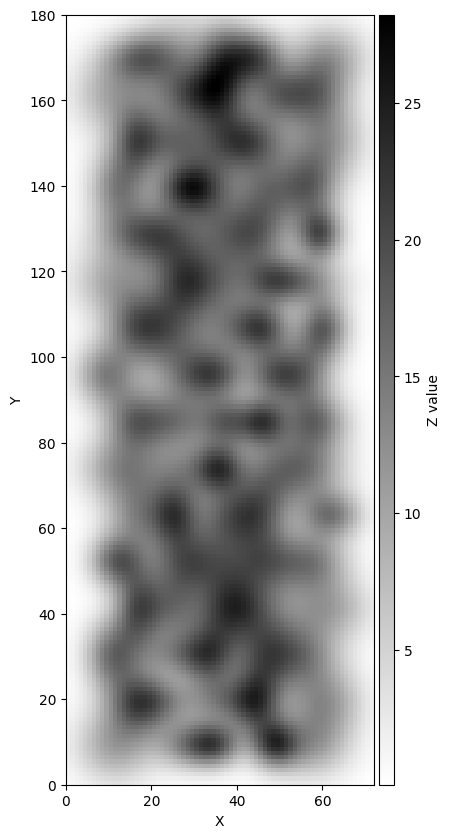

In [22]:
fig, ax = plt.subplots(figsize=(15, 10))
plot_grayscale(x, y, mat["F_data"][:, :, 0], ax=ax)

# [ESTIMATION PART I and II]
- Images: 400
- predict_T80kenji

## [ESTIMATION] Pipeline ppl_Yolo DS-IE

In [ ]:
# Load our custom model
model_dsie = YOLO(f"../docs/Models/{"YOLOv0_E12_detect"}/runs/{bst_run['YOLOv0_E12_detect']}/{NOTEBOOK_CONFIG['task']}/train/weights/best.pt")

In [ ]:
# Make the prediction
img = cv2.imread(image_path)
results = model_dsie.predict(img)

# class 0 boxes
tensor_boxes = results[0].boxes.xyxy

# Centers
means_yolo = [
    (float(x), float(y))
    for x, y in zip(
        results[0].boxes.xywhn[:, 0] * NOTEBOOK_CONFIG["image_size"][0],
        results[0].boxes.xywhn[:, 1] * NOTEBOOK_CONFIG["image_size"][1],
    )
]

## [ESTIMATION] Pipeline ppl_Yolo - Retrained

### Predict with custom model - YOLOv0

In [24]:
os.listdir("../docs/Models")

['YOLOv0_detect',
 'YOLOv0_E2_detect',
 'YOLOv0_E3_detect',
 'YOLOv0_E12_detect',
 'YOLOv0_E4_detect',
 'Archive',
 'YOLOv0_E1_detect',
 'YOLOv0_T80kenji_detect']

In [25]:
os.listdir("../docs/Models/YOLOv0_T80kenji_detect/datasets/test/images/")

['gaussian_208.png',
 'gaussian_304.png',
 'gaussian_262.png',
 'gaussian_288.png',
 'gaussian_77.png',
 'gaussian_230.png',
 'gaussian_45.png',
 'gaussian_115.png',
 'gaussian_172.png',
 'gaussian_188.png',
 'gaussian_93.png',
 'gaussian_323.png',
 'gaussian_371.png',
 'gaussian_8.png',
 'gaussian_285.png',
 'gaussian_200.png',
 'gaussian_383.png',
 'gaussian_365.png',
 'gaussian_297.png',
 'gaussian_31.png',
 'gaussian_28.png',
 'gaussian_193.png',
 'gaussian_322.png',
 'gaussian_144.png',
 'gaussian_286.png',
 'gaussian_191.png',
 'gaussian_155.png',
 'gaussian_291.png',
 'gaussian_109.png',
 'gaussian_194.png',
 'gaussian_97.png',
 'gaussian_209.png',
 'gaussian_310.png',
 'gaussian_301.png',
 'gaussian_70.png',
 'gaussian_324.png',
 'gaussian_4.png',
 'gaussian_357.png',
 'gaussian_57.png',
 'gaussian_242.png']

In [44]:
# Make the prediction
img = cv2.imread(image_path)
results = model.predict(img)

# class 0 boxes
tensor_boxes_new = results[0].boxes.xyxy

# Centers
means = [
    (float(x), float(y))
    for x, y in zip(
        results[0].boxes.xywhn[:, 0] * NOTEBOOK_CONFIG["image_size"][0],
        results[0].boxes.xywhn[:, 1] * NOTEBOOK_CONFIG["image_size"][1],
    )
]


0: 640x256 80 gaussians, 1497.2ms
Speed: 1.8ms preprocess, 1497.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


Number of indentifiable Gaussians (center in the image): 80


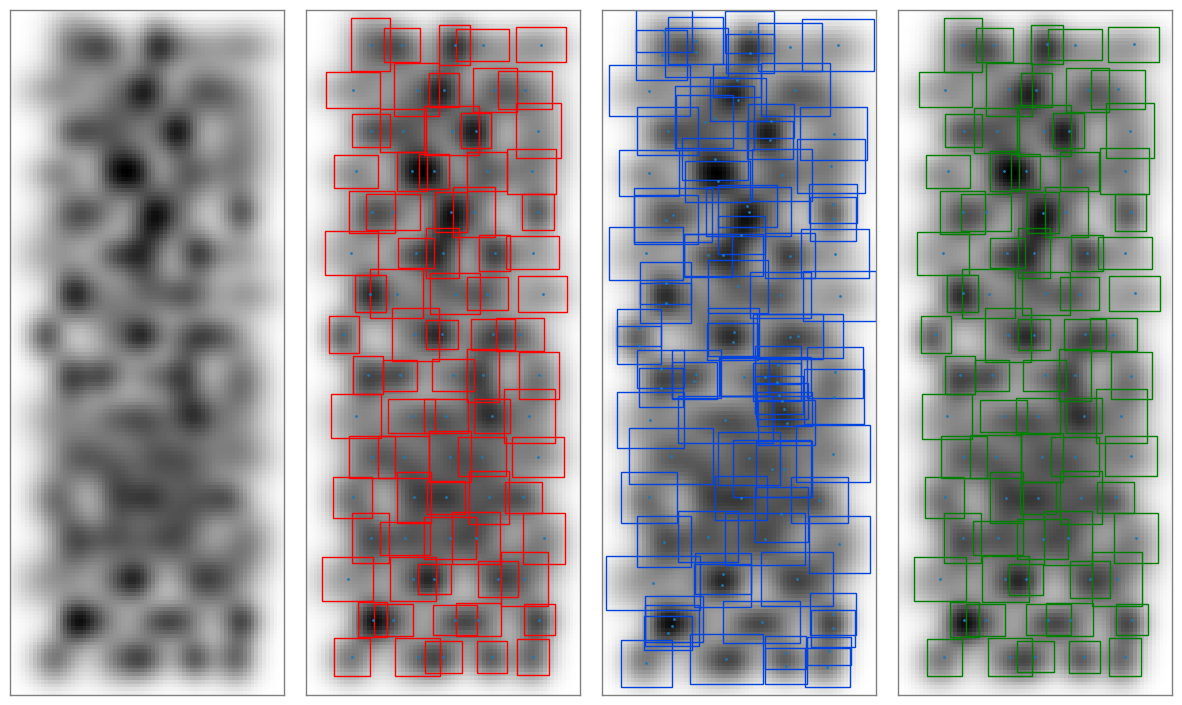

In [45]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 4, figsize=(15, 20))

# Display the image and plot predicted centers GMM
axs[2].imshow(im)
plot_boxes(tensor_boxes, axs[2], edge_color="#0343DF")
axs[2].set_ylim(ax.get_ylim()[::-1])
axs[2].scatter(np.array(means_yolo)[:, 0], np.array(means_yolo)[:, 1], s=1)
# axs[3].axis('off')
axs[2].set_xlim(0, NOTEBOOK_CONFIG["IMG_XDIM"])
axs[2].set_ylim(0, NOTEBOOK_CONFIG["IMG_YDIM"])


# Display the image and plot predicted centers
axs[3].imshow(im)
plot_boxes(tensor_boxes_new, axs[3], edge_color="g")
axs[3].set_ylim(axs[2].get_ylim()[::-1])
axs[3].scatter(np.array(means)[:, 0], np.array(means)[:, 1], s=1)
# axs[2].axis('off')
axs[3].set_xlim(0, NOTEBOOK_CONFIG["IMG_XDIM"])
axs[3].set_ylim(0, NOTEBOOK_CONFIG["IMG_YDIM"])

# axs[2].set_title("Prediction")

# Labelling
x, y, z = gaussians_labelled(
    image_path,
    label_path,
    axs[1],
    task=NOTEBOOK_CONFIG["task"],
    colorbar=False,
    plot_centers=True,
    grid_width=NOTEBOOK_CONFIG["image_ranges"][0][-1],
    grid_length=NOTEBOOK_CONFIG["image_ranges"][1][-1],
    img_width=NOTEBOOK_CONFIG["image_size"][0],
    img_length=NOTEBOOK_CONFIG["image_size"][1],
)
# axs[1].axis('off')
axs[1].set_xlim(0, NOTEBOOK_CONFIG["IMG_WIDTH"])
axs[1].set_ylim(0, NOTEBOOK_CONFIG["IMG_LENGTH"])
# axs[1].set_title("Ground Truth")

# Image
plot_grayscale(x, y, z, colorbar=False, ax=axs[0])
# axs[0].axis('off')
axs[0].set_xlim(0, NOTEBOOK_CONFIG["IMG_WIDTH"])
axs[0].set_ylim(0, NOTEBOOK_CONFIG["IMG_LENGTH"])


for ax in axs:
    ax.xaxis.label.set_text("")
    ax.yaxis.label.set_text("")

    ax.set_xticks([])
    ax.set_yticks([])
    # Change the color of the axis spines (borders)
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")
        spine.set_linewidth(1)

plt.subplots_adjust(wspace=0.08)
plt.show()

### Error evaluation

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(
    f"../docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/"
)
eval_images = [
    int(i.split("_")[1].split(".")[0]) for i in images_test
]  # Use the same images of the test from YOLO
print(eval_images)
print(len(eval_images))

[208, 304, 262, 288, 77, 230, 45, 115, 172, 188, 93, 323, 371, 8, 285, 200, 383, 365, 297, 31, 28, 193, 322, 144, 286, 191, 155, 291, 109, 194, 97, 209, 310, 301, 70, 324, 4, 357, 57, 242]
40


In [ ]:
# Iterate all images - GMM method
results = {
    "Image": [],
    "Number identified - YOLO": [],
    "Number identifiable - YOLO": [],
    "Percentage - YOLO": [],
    "RMSE_cx - YOLO": [],
    "RMSE_cy - YOLO": [],
    "RMSE_c - YOLO": [],
    "RMSE_sigmax - YOLO": [],
    "RMSE_sigmay - YOLO": [],
    "RMSE_sigma - YOLO": [],
    "MaxE_sigmax - YOLO": [],
    "MaxE_sigmay - YOLO": [],
    "MaxE_sigma - YOLO": [],
    "RMSE_amplitude - YOLO": [],
    "RMSEPixel - YOLO": [],
}

for n_image in eval_images:
    eval_gaussian = ppl_error_estimation(
        n_image,
        mat,
        estimation_method="YOLO",
        image_path="../docs/Data/Images_T80kenji/",
        yolo_model=model,
        covariance_gaussians_types="diag",
        return_percentage=True,
        image_ranges=NOTEBOOK_CONFIG["image_ranges"],
        image_size=NOTEBOOK_CONFIG["image_size"],
    )
    # Append values in the dictionary
    for key in results.keys():
        if key in eval_gaussian:
            results[key] += eval_gaussian[key]


0: 640x256 80 gaussians, 196.0ms
Speed: 1.5ms preprocess, 196.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.7139           0]
  [          0      4.7234]]]
covariances true [[[     3.6841           0]
  [          0       4.709]]]


0: 640x256 80 gaussians, 179.1ms
Speed: 1.4ms preprocess, 179.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.8604           0]
  [          0      4.4676]]]
covariances true [[[     3.8343           0]
  [          0      4.5156]]]


0: 640x256 80 gaussians, 181.4ms
Speed: 1.6ms preprocess, 181.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.0351           0]
  [          0      6.2795]]]
covariances true [[[     4.0542           0]
  [          0      6.0914]]]


0: 640x256 80 gaussians, 182.9ms
Speed: 1.5ms preprocess, 182.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.7345           0]
  [          0      4.7311]]]
covariances true [[[     4.6503           0]
  [          0       4.771]]]


0: 640x256 80 gaussians, 173.2ms
Speed: 3.9ms preprocess, 173.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.8546           0]
  [          0      5.7056]]]
covariances true [[[     3.8296           0]
  [          0      5.7002]]]


0: 640x256 80 gaussians, 174.8ms
Speed: 1.2ms preprocess, 174.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[      4.276           0]
  [          0      5.3679]]]
covariances true [[[     4.3167           0]
  [          0      5.4438]]]


0: 640x256 80 gaussians, 175.8ms
Speed: 1.2ms preprocess, 175.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.6877           0]
  [          0      4.9438]]]
covariances true [[[     3.7386           0]
  [          0      5.0817]]]


0: 640x256 80 gaussians, 170.9ms
Speed: 1.0ms preprocess, 170.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.1811           0]
  [          0      5.1158]]]
covariances true [[[     4.1495           0]
  [          0      5.2987]]]


0: 640x256 80 gaussians, 174.0ms
Speed: 1.5ms preprocess, 174.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.2677           0]
  [          0      4.0109]]]
covariances true [[[     4.2121           0]
  [          0      4.0225]]]


0: 640x256 80 gaussians, 180.0ms
Speed: 1.2ms preprocess, 180.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.1118           0]
  [          0      4.8813]]]
covariances true [[[     4.0771           0]
  [          0      4.8919]]]


0: 640x256 80 gaussians, 173.6ms
Speed: 1.1ms preprocess, 173.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.6955           0]
  [          0      4.0311]]]
covariances true [[[     3.6804           0]
  [          0      3.9541]]]


0: 640x256 80 gaussians, 182.9ms
Speed: 1.6ms preprocess, 182.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.6275           0]
  [          0      5.2412]]]
covariances true [[[     4.5784           0]
  [          0      5.1856]]]


0: 640x256 80 gaussians, 182.9ms
Speed: 1.5ms preprocess, 182.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.8195           0]
  [          0      5.6718]]]
covariances true [[[     3.8404           0]
  [          0      5.7511]]]


0: 640x256 80 gaussians, 184.1ms
Speed: 1.4ms preprocess, 184.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.3044           0]
  [          0      5.1749]]]
covariances true [[[     4.3395           0]
  [          0      5.1717]]]


0: 640x256 80 gaussians, 175.3ms
Speed: 1.4ms preprocess, 175.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.7362           0]
  [          0      5.0657]]]
covariances true [[[     3.7269           0]
  [          0      5.1137]]]


0: 640x256 80 gaussians, 199.1ms
Speed: 1.0ms preprocess, 199.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.8888           0]
  [          0      3.8647]]]
covariances true [[[     4.8194           0]
  [          0      3.8017]]]


0: 640x256 80 gaussians, 240.6ms
Speed: 1.5ms preprocess, 240.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.6683           0]
  [          0      4.5183]]]
covariances true [[[     3.6335           0]
  [          0      4.4822]]]


0: 640x256 80 gaussians, 242.1ms
Speed: 1.1ms preprocess, 242.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.7607           0]
  [          0      4.1319]]]
covariances true [[[     3.7589           0]
  [          0      4.1235]]]


0: 640x256 80 gaussians, 238.5ms
Speed: 1.0ms preprocess, 238.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.8115           0]
  [          0      4.2804]]]
covariances true [[[     3.7979           0]
  [          0       4.311]]]


0: 640x256 80 gaussians, 246.3ms
Speed: 1.1ms preprocess, 246.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.6853           0]
  [          0      4.8712]]]
covariances true [[[     3.6653           0]
  [          0      4.9033]]]


0: 640x256 80 gaussians, 242.0ms
Speed: 1.1ms preprocess, 242.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.7964           0]
  [          0      5.9736]]]
covariances true [[[     4.8513           0]
  [          0      6.0477]]]


0: 640x256 80 gaussians, 242.7ms
Speed: 1.6ms preprocess, 242.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.3546           0]
  [          0      5.1906]]]
covariances true [[[     4.3031           0]
  [          0      5.1851]]]


0: 640x256 80 gaussians, 255.4ms
Speed: 1.1ms preprocess, 255.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.9396           0]
  [          0      6.6877]]]
covariances true [[[     3.8855           0]
  [          0      6.6747]]]


0: 640x256 80 gaussians, 203.8ms
Speed: 1.2ms preprocess, 203.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.7391           0]
  [          0      5.5256]]]
covariances true [[[     4.7916           0]
  [          0      5.5951]]]


0: 640x256 80 gaussians, 177.6ms
Speed: 1.1ms preprocess, 177.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.0021           0]
  [          0      5.3089]]]
covariances true [[[     4.0142           0]
  [          0      5.3216]]]


0: 640x256 80 gaussians, 176.6ms
Speed: 3.7ms preprocess, 176.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.2771           0]
  [          0      5.5285]]]
covariances true [[[      4.208           0]
  [          0      5.5603]]]


0: 640x256 80 gaussians, 184.0ms
Speed: 1.0ms preprocess, 184.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.9594           0]
  [          0      4.4052]]]
covariances true [[[     3.9148           0]
  [          0      4.3894]]]


0: 640x256 80 gaussians, 189.5ms
Speed: 1.6ms preprocess, 189.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.4467           0]
  [          0       4.935]]]
covariances true [[[     4.3988           0]
  [          0      4.9509]]]


0: 640x256 80 gaussians, 183.4ms
Speed: 1.5ms preprocess, 183.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.9319           0]
  [          0      3.8643]]]
covariances true [[[     3.8382           0]
  [          0      3.8348]]]


0: 640x256 80 gaussians, 183.4ms
Speed: 1.1ms preprocess, 183.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.9747           0]
  [          0      4.0307]]]
covariances true [[[     3.9764           0]
  [          0      4.1154]]]


0: 640x256 80 gaussians, 179.8ms
Speed: 1.4ms preprocess, 179.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.6865           0]
  [          0      4.6988]]]
covariances true [[[     3.7565           0]
  [          0      4.7438]]]


0: 640x256 80 gaussians, 187.1ms
Speed: 1.3ms preprocess, 187.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.8359           0]
  [          0      5.1353]]]
covariances true [[[     3.8355           0]
  [          0      5.0907]]]


0: 640x256 80 gaussians, 173.5ms
Speed: 1.0ms preprocess, 173.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.6872           0]
  [          0      4.5969]]]
covariances true [[[     3.6544           0]
  [          0      4.5779]]]


0: 640x256 80 gaussians, 181.3ms
Speed: 4.6ms preprocess, 181.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.5153           0]
  [          0      5.6337]]]
covariances true [[[     4.4748           0]
  [          0      5.5943]]]


0: 640x256 80 gaussians, 183.8ms
Speed: 1.0ms preprocess, 183.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     5.0796           0]
  [          0      3.8699]]]
covariances true [[[     5.1142           0]
  [          0      3.9174]]]


0: 640x256 80 gaussians, 176.6ms
Speed: 3.2ms preprocess, 176.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.9358           0]
  [          0      5.8752]]]
covariances true [[[     3.9395           0]
  [          0      6.0127]]]


0: 640x256 80 gaussians, 178.5ms
Speed: 1.5ms preprocess, 178.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.7439           0]
  [          0      4.9235]]]
covariances true [[[     3.7062           0]
  [          0      4.9921]]]


0: 640x256 80 gaussians, 176.1ms
Speed: 1.3ms preprocess, 176.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.4925           0]
  [          0      5.5928]]]
covariances true [[[     4.5051           0]
  [          0      5.6444]]]


0: 640x256 80 gaussians, 181.7ms
Speed: 1.3ms preprocess, 181.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.0577           0]
  [          0      6.1018]]]
covariances true [[[          4           0]
  [          0      6.2132]]]


0: 640x256 80 gaussians, 176.5ms
Speed: 1.2ms preprocess, 176.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     4.3198           0]
  [          0      4.8167]]]
covariances true [[[     4.3199           0]
  [          0      4.8484]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[["mean", "std", "max"]].T

,mean,std,max
Image,203.22,112.45,383.00
Number identified - YOLO,80.00,0.00,80.00
Number identifiable - YOLO,80.00,0.00,80.00
Percentage - YOLO,100.00,0.00,100.00
RMSE_cx - YOLO,0.42,0.06,0.57
RMSE_cy - YOLO,0.11,0.03,0.19
RMSE_c - YOLO,0.44,0.06,0.58
RMSE_sigmax - YOLO,1.66,0.17,1.96
RMSE_sigmay - YOLO,1.74,0.24,2.44
RMSE_sigma - YOLO,2.41,0.23,2.99


In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values("Image")

,Image,Number identified - YOLO,Number identifiable - YOLO,Percentage - YOLO,RMSE_cx - YOLO,RMSE_cy - YOLO,RMSE_c - YOLO,RMSE_sigmax - YOLO,RMSE_sigmay - YOLO,RMSE_sigma - YOLO,MaxE_sigmax - YOLO,MaxE_sigmay - YOLO,MaxE_sigma - YOLO,RMSE_amplitude - YOLO,RMSEPixel - YOLO
36,4,80,80,100.0,0.37,0.10,0.38,1.62,1.90,2.50,9.99,6.61,11.98,50.19,3.10
13,8,80,80,100.0,0.44,0.12,0.45,1.95,1.73,2.61,10.63,7.95,13.28,50.70,2.91
20,28,80,80,100.0,0.49,0.07,0.50,1.55,1.94,2.48,11.94,10.19,15.70,49.55,2.98
19,31,80,80,100.0,0.43,0.12,0.44,1.52,1.69,2.27,8.14,8.93,12.08,51.23,3.15
6,45,80,80,100.0,0.33,0.13,0.36,1.45,1.47,2.07,6.01,6.37,8.76,54.08,3.14
38,57,80,80,100.0,0.57,0.11,0.58,1.75,1.64,2.40,10.02,5.96,11.66,52.08,3.03
34,70,80,80,100.0,0.39,0.10,0.40,1.96,1.92,2.74,9.91,8.27,12.91,54.93,3.17
4,77,80,80,100.0,0.35,0.10,0.36,1.55,1.55,2.19,5.48,7.80,9.54,47.69,2.96
10,93,80,80,100.0,0.42,0.09,0.43,1.43,1.50,2.07,7.33,5.59,9.22,52.88,2.96
30,97,80,80,100.0,0.51,0.09,0.52,1.68,1.64,2.34,8.25,10.00,12.97,52.53,3.14


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""../docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(
    snapshot_folder_path=snapshot_folder_path,
    error_dataframe=pd.DataFrame.from_dict(results).sort_values("Image"),
    annotation=f"""Amplitudes estimated using the center directly\n
                 image_path = {"../docs/Data/Images_T80kenji/"}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
    name="T80kenjiYOLO",
)